In [1]:
import glob
import numpy  as np
import tables as tb
# import pandas as pd
# to_df = pd.DataFrame.from_records

import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from invisible_cities.database          import load_db

from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms

from invisible_cities.core.system_of_units_c import units
adc, pes, mus = units.adc, units.pes, units.mus

from invisible_cities.cities.components import deconv_pmt
from invisible_cities.cities.components import calibrate_pmts
from invisible_cities.cities.components import calibrate_sipms
from invisible_cities.cities.components import zero_suppress_wfs

from invisible_cities.reco.peak_functions import split_in_peaks
from invisible_cities.reco.peak_functions import select_peaks
from invisible_cities.reco.peak_functions import select_wfs_above_time_integrated_thr
from invisible_cities.reco.peak_functions import pick_slice_and_rebin

from invisible_cities.types.ic_types import minmax

## Import raw waveforms

In [2]:
run = 7600
wfs_dir        = f"/home/gdiaz/IRENE_NOTEBOOKS/DATA/waveforms/{run}/"
wfs_files = glob.glob( wfs_dir + "/*" )
wfs_files.sort()

## Parameters

In [3]:
files_in  = wfs_files
file_out  = "pmaps.h5"

run_number = 7600
assert run_number==run
n_baseline = 62400 

n_mau   = 100
thr_mau =   3 * adc

thr_csum_s1 = 0.5 * pes
thr_csum_s2 = 2.0 * pes

thr_sipm   = 1.0 * pes    
thr_sipm_type = "Common"

s1_tmin   =   0 * mus 
s1_tmax   = 790 * mus 
s1_stride =   4       
s1_lmin   =   5       
s1_lmax   =  30      
s1_rebin_stride = 1

s2_tmin   =      0 * mus 
s2_tmax   =   1601 * mus 
s2_stride =     40      
s2_lmin   =     80       
s2_lmax   = 200000       
s2_rebin_stride = 40   

thr_sipm_s2 = 5 * pes  

detector_db = "new" ## Added by me

if thr_sipm_type.lower() == "common": 
    sipm_thr = thr_sipm

## Select file and waveform

In [4]:
file_number = 0

RWFs_file = tb.open_file(files_in[file_number])
pmt_rwfs_all  = RWFs_file.root.RD.pmtrwf
sipm_rwfs_all = RWFs_file.root.RD.sipmrwf
time_stamps   = RWFs_file.root.Run.events

#select random waveform
i = int( np.random.random()* (len(time_stamps) - 1) )
event_time = time_stamps[i]


pmt_rwfs  = pmt_rwfs_all [i]
sipm_rwfs = sipm_rwfs_all[i]

RWFs_file.close()

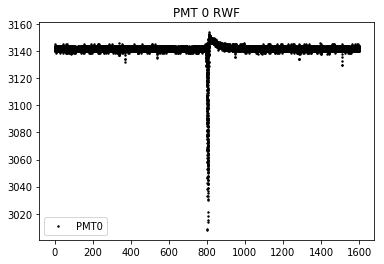

In [5]:
pmt = 0

times = np.arange(pmt_rwfs.shape[1])*25/1000
plt.scatter(times, pmt_rwfs[pmt], c="black", s=2, label=f"PMT{pmt}")
plt.legend()
plt.title(f"PMT {pmt} RWF");

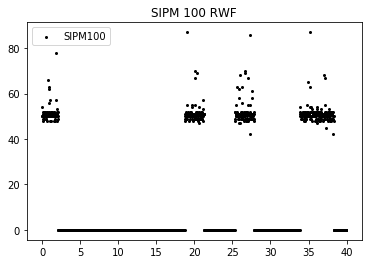

In [6]:
sipm = 100

times = np.arange(sipm_rwfs.shape[1])*25/1000
plt.scatter(times, sipm_rwfs[sipm], c="black", s=4, label=f"SIPM{sipm}")
plt.legend()
plt.title(f"SIPM {sipm} RWF");

## PMT processing

In [7]:
rwf_to_cwf = deconv_pmt    (detector_db, run_number, n_baseline)
pmt_cwfs   = rwf_to_cwf    (pmt_rwfs)

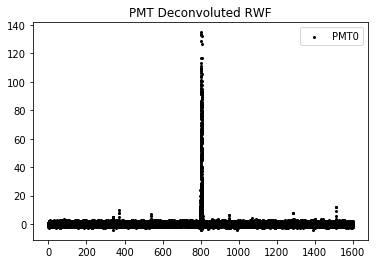

In [8]:
pmt=0

times = np.arange(pmt_cwfs.shape[1])*25/1000
plt.scatter(times, pmt_cwfs[pmt], c="black", s=4, label=f"PMT{pmt}")
plt.legend()
plt.title("PMT Deconvoluted RWF");

In [9]:
cwf_to_ccwf = calibrate_pmts(detector_db, run_number, n_mau, thr_mau)
pmt_ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau  = cwf_to_ccwf    (pmt_cwfs)

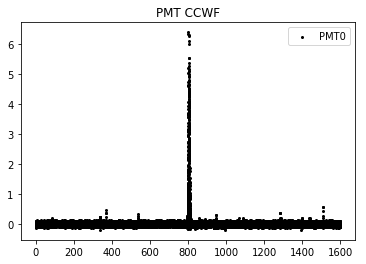

In [10]:
pmt=0

times = np.arange(pmt_ccwfs.shape[1])*25/1000
plt.scatter(times, pmt_ccwfs[0], c="black", s=4, label=f"PMT{pmt}")
plt.legend()
plt.title("PMT CCWF");

## SIPM processing

In [11]:
sipm_rwf_to_cal = calibrate_sipms(detector_db, run_number, sipm_thr)
sipm_cwfs = sipm_rwf_to_cal(sipm_rwfs)

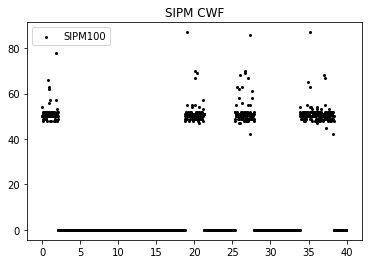

In [12]:
sipm = 100

times = np.arange(sipm_rwfs.shape[1])*25/1000
plt.scatter(times, sipm_rwfs[sipm], c="black", s=4, label=f"SIPM{sipm}")
plt.legend()
plt.title("SIPM CWF");

## Find S1 and S2 peaks (IRENE)

In [13]:
zero_suppress = zero_suppress_wfs(thr_csum_s1, thr_csum_s2)
s1_indices, s2_indices = zero_suppress(cwf_sum, cwf_sum_mau)

In [14]:
indices_split   = split_in_peaks(s1_indices, s1_stride)
    
time    = minmax(min = s1_tmin, max = s1_tmax)
length  = minmax(min = s1_lmin, max = s1_lmax)
    
s1_selected_splits = select_peaks  (indices_split, time, length)

print("Number of S1 candidates:", len(s1_selected_splits))

Number of S1 candidates: 1


In [15]:
indices_split   = split_in_peaks(s2_indices, s2_stride)
    
time    = minmax(min = s2_tmin, max = s2_tmax)
length  = minmax(min = s2_lmin, max = s2_lmax)
    
s2_selected_splits = select_peaks  (indices_split, time, length)

print("Number of S2 candidates:", len(s2_selected_splits))

Number of S2 candidates: 1


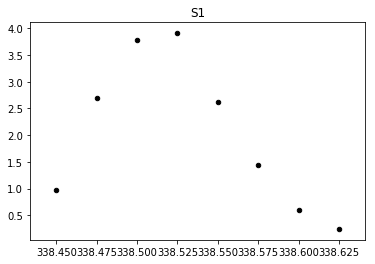

In [16]:
i = 0 

s1_pmt = np.sum( pmt_ccwfs[:, s1_selected_splits[i][0]: s1_selected_splits[i][-1]], axis=0)

times = np.arange(s1_selected_splits[i][0], s1_selected_splits[i][-1])*25/1000
plt.scatter(times, s1_pmt, c="black", s=20)
plt.title("S1");

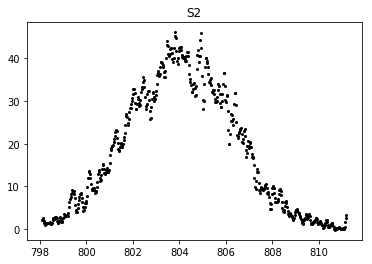

In [17]:
i = 0

s2_pmt = np.sum( pmt_ccwfs[:, s2_selected_splits[i][0]: s2_selected_splits[i][-1]], axis=0)

times = np.arange(s2_selected_splits[0][0], s2_selected_splits[0][-1])*25/1000
plt.scatter(times, s2_pmt, c="black", s=4)
plt.title("S2");

In [18]:
from scipy import optimize

def gauss(x, A, mu, sig):
    return A*np.exp( -(x-mu)**2/(2*sig**2) )

p0 = [np.max(s2_pmt), np.mean(times), times[-1]-times[0]]
res, cov = optimize.curve_fit(gauss, times, s2_pmt, 
                              p0=p0,
                              bounds=[(0, -np.inf, 0), (np.inf, np.inf, np.inf)])

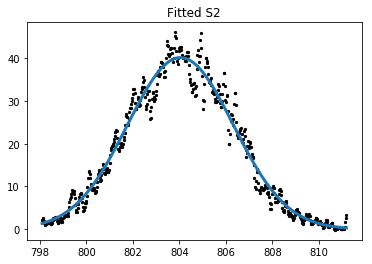

In [19]:
plt.scatter(times, s2_pmt, c="black", s=5)
plt.plot   (times, gauss(times, *res), linewidth=3)
plt.title("Fitted S2");

### Event Z position

In [20]:
if (len(s1_selected_splits))==1 & len(s2_selected_splits)==1:
    
    s1_pmt = np.sum( pmt_ccwfs[:, s1_selected_splits[0][0]: s1_selected_splits[0][-1]], axis=0)
    times = np.arange(s1_selected_splits[0][0], s1_selected_splits[0][-1])*25/1000
    
    S1_time = np.sum( s1_pmt*times ) / np.sum(s1_pmt)

else:
    raise Exception("Z is not defined")

## Find S2 peaks (+/- 10 $\mu s$)

In [21]:
def find_peaks(cwf_sum, dt=10, m_thr=10):
    '''Given the sum of the corrected waveforms, it returns the 
    indexes and values of the S2s found by considering the maximum 
    value in the waveform with a +/- dt micro-seconds window. Several
    S2s are returned meanwhile the maximum value in the waveform is 
    above m_thr'''
    wf = cwf_sum.copy()
    peaks=[]
    
    dt = dt*40
    
    times = np.arange(wf.shape[0])
    m=np.max(wf)
    
    while m>=m_thr:
        max_time  = times[ wf==m ]
        idxs = np.arange(max_time-dt, max_time+dt)
        sel_in_range = (times[0]<=idxs)&(idxs<=times[-1])
        idxs = idxs[sel_in_range]
        
        select_s2 = wf[idxs]
        peaks.append((idxs, select_s2))
        
        wf[idxs]=0
        m=np.max(wf)
        
    return peaks

In [22]:
peaks = find_peaks(cwf_sum, dt=10, m_thr=10)

print("Number of peaks:", len(peaks) )

Number of peaks: 1


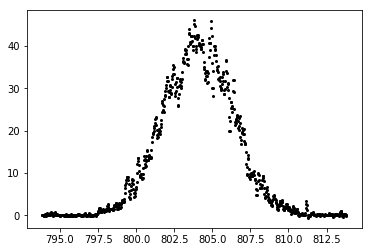

In [23]:
pk=0
plt.scatter(peaks[pk][0]*25/1000, peaks[pk][1], c="black", s=4);

## SIPM S2 peak

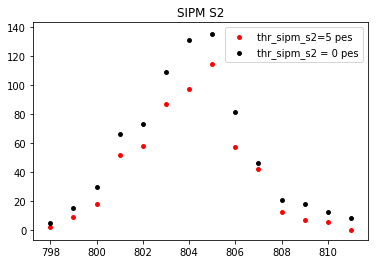

In [24]:
i = 0

a = s2_selected_splits[i][0]  // 40 
b = s2_selected_splits[i][-1] // 40 + 1
times   = np.arange(a, b)

sipm_wfs_ = sipm_cwfs[:, a:b]
sipm_ids, sipm_wfs = select_wfs_above_time_integrated_thr(sipm_wfs_, thr_sipm_s2)

plt.scatter(times, np.sum( sipm_wfs, axis=0), s=15, c="red", label="thr_sipm_s2=5 pes")

sipm_s2 = np.sum( sipm_cwfs, axis=0)[a:b]
plt.scatter(times, sipm_s2, s=15, c="black", label="thr_sipm_s2 = 0 pes")
plt.legend()
plt.title("SIPM S2");

## From produced pmaps

In [25]:
run = 7600
pmaps_dir = f"/home/gdiaz/IRENE_NOTEBOOKS/DATA/pmaps/{run}/trigger1/"

pmaps_files = glob.glob( pmaps_dir + "/*" )
pmaps_files.sort()

In [26]:
pmaps = tb.open_file( pmaps_files[file_number] )
S2   = pmaps.root.PMAPS.S2  .read()
S2Si = pmaps.root.PMAPS.S2Si.read()

In [27]:
if len(S2[S2["event"]==event_time[0]])==0:
    print("Requested event is not in official PMAPs files")

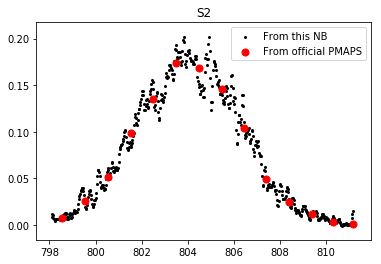

In [28]:
i = 0

# S2 from this NB processing
s2_pmt = np.sum( pmt_ccwfs[:, s2_selected_splits[i][0]: s2_selected_splits[i][-1]], axis=0)
times = np.arange(s2_selected_splits[i][0], s2_selected_splits[i][-1])*25/1000
plt.scatter(times, s2_pmt/ np.sum( s2_pmt * 25/1000 ), c="black", s=4, 
            label="From this NB")


# S2 taken from official pmaps
sel = (S2["event"]==event_time[0]) & (S2["peak"]==i)
plt.scatter(S2[sel]["time"]/1000, S2[sel]["ene"] / np.sum(S2[sel]["ene"]*1), c="r", s=50, 
            label="From official PMAPS")
plt.title("S2");
plt.legend();

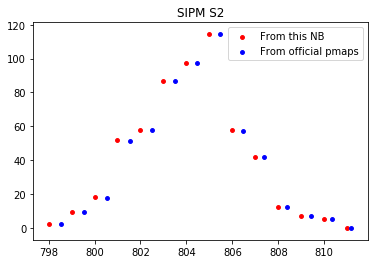

In [29]:
i = 0

# S2Si from this NB processing
a = s2_selected_splits[i][0]  // 40 
b = s2_selected_splits[i][-1] // 40 + 1

sipm_wfs_ = sipm_cwfs[:, a:b]
sipm_ids, sipm_wfs = select_wfs_above_time_integrated_thr(sipm_wfs_, thr_sipm_s2)

sipm_s2 = np.sum( sipm_cwfs, axis=0)    [a : b]
times   = np.arange(a, b)
plt.scatter(times, np.sum( sipm_wfs, axis=0), s=15, c="red", label="From this NB")
plt.title("SIPM S2");


# S2Si from official pmaps
sel = (S2["event"]==event_time[0]) & (S2["peak"]==i)
times = S2[sel]["time"]/1000

sel = (S2Si["event"]==event_time[0])&(S2Si["peak"]==i)
sipms, idxs = np.unique(S2Si[sel]["nsipm"], return_index=True)
sipm_wfs    = np.array( np.split(S2Si[sel], idxs[1:]) )

plt.scatter(times, np.sum( sipm_wfs["ene"], axis=0), s=15, c="b", label="From official pmaps")
plt.title("SIPM S2")
plt.legend();

## Rebinning

In [30]:
i = 0

times  = np.arange     (pmt_ccwfs.shape[1]) * 25 * units.ns
widths = np.full       (pmt_ccwfs.shape[1],   25 * units.ns)

indices = s2_selected_splits[i]
wfs     = pmt_ccwfs

with_sipms = True

rebinned_times, rebinned_widths, rebinned_ccwfs = pick_slice_and_rebin(indices, times, widths,
                                                                       wfs, rebin_stride=s2_rebin_stride, 
                                                                       pad_zeros=with_sipms)

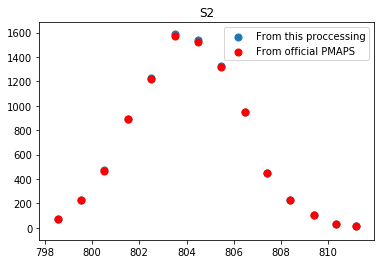

In [31]:
# S2 from this NB rebinned
plt.scatter(rebinned_times/1000, np.sum(rebinned_ccwfs, axis=0), s=50,
            label="From this proccessing") 

# S2 taken from official pmaps
sel = (S2["event"]==event_time[0]) & (S2["peak"]==i)
plt.scatter(S2[sel]["time"]/1000, S2[sel]["ene"], c="r", s=50, 
            label="From official PMAPS")
plt.title("S2");
plt.legend();

## Plot peak

In [32]:
datapmt  = load_db.DataPMT ("new", run)
datasipm = load_db.DataSiPM("new", run)
n_sipms  = len(datasipm)

def plot_event(pmt_data, sipm_data):
    
    fig = plt.figure(figsize=[15, 5])
    ax_ep = fig.add_subplot(121)
    ax_tp = fig.add_subplot(122)

    X = datapmt["X"].values
    Y = datapmt["Y"].values
    ax_ep.scatter(X, Y, 
                  s = pmt_data/np.sum(pmt_data)*1e4,
                  c=pmt_data/np.sum(pmt_data),
                  cmap="Reds")

    X = datasipm["X"].values
    Y = datasipm["Y"].values
    ax_tp.scatter(X, Y, 
                  s = sipm_data,
                  c = sipm_data/ 1e4,
                  cmap="Reds") ;
    
def plot_TP_event(sipm_data):

    fig = plt.figure(figsize=[6, 4])
    ax = fig.add_subplot(111)
    
    X = datasipm["X"].values
    Y = datasipm["Y"].values
    ax.scatter(X, Y, 
               s = sipm_data,
               c = sipm_data,
               cmap="jet") ;
    
    
def apply_sipm_s2_thr(s2_sipms, thr):
    """This function is equivalent to  select_wfs_above_time_integrated_thr, 
    but returning all wfs intead a selection"""
    n_sipms = s2_sipms.shape[0]
    cond         = (np.sum(s2_sipms, axis=1)>=thr).reshape((n_sipms, 1))
    s2_sipms_thr = np.where( cond, s2_sipms, np.zeros(s2_sipms.shape[1]) )
    return s2_sipms_thr

In [33]:
i = 0

s2_pmts = pmt_ccwfs[:, s2_selected_splits[i][0]: s2_selected_splits[i][-1]]

a = s2_selected_splits[i][0]  // 40 
b = s2_selected_splits[i][-1] // 40 + 1
s2_sipms = sipm_cwfs[: , a:b]

s2_sipms = sipm_cwfs[: , a:b]

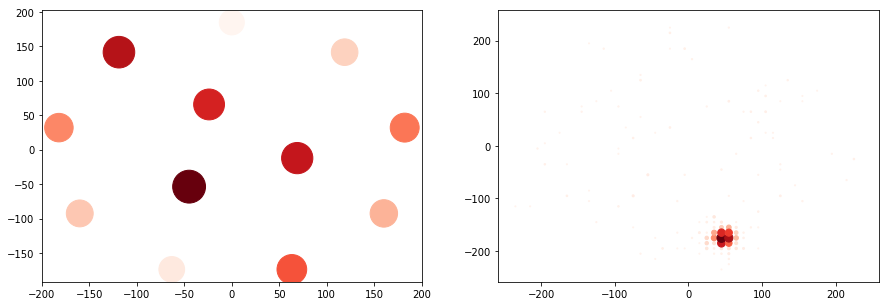

In [34]:
pmt_data  = np.sum( s2_pmts , axis=1)
sipm_data = np.sum( s2_sipms, axis=1)

plot_event(pmt_data, sipm_data)

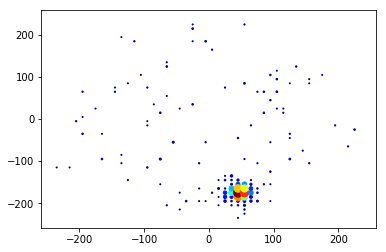

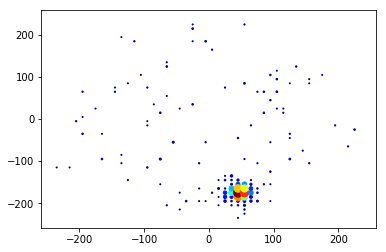

In [35]:
for i in range(0, 2):
    s2_sipms_thr = apply_sipm_s2_thr(s2_sipms, i)
    plot_TP_event( np.sum(s2_sipms_thr, axis=1) )

## Corrected peak

$$ E_{corrected}(t) = E_{measured}(t) ~ \times ~ \sum_{i ~ \in ~ sipm} \frac{q_i }{Q} ~ \times ~ \text{correction-factor}_i (t) ~ $$

In [36]:
from invisible_cities.reco.corrections_new import read_maps
from invisible_cities.reco.corrections_new import apply_all_correction
from invisible_cities.reco.corrections_new import norm_strategy

In [37]:
maps = read_maps("/home/gdiaz/IRENE_NOTEBOOKS/DATA/maps/map_7600.h5")

total_correction = apply_all_correction(maps, apply_temp=True)
#                                         norm_strat=norm_strategy.custom,
#                                         norm_value=10)

def apply_sipm_s2_thr(s2_sipms, thr):
    """This function is equivalent to  select_wfs_above_time_integrated_thr, 
    but returning all wfs intead a selection"""
    n_sipms = s2_sipms.shape[0]
    cond         = (np.sum(s2_sipms, axis=1)>=thr).reshape((n_sipms, 1))
    s2_sipms_thr = np.where( cond, s2_sipms, np.zeros(s2_sipms.shape[1]) )
    return s2_sipms_thr

In [38]:
i = 0

# S2 PMT
rebinned_times, rebinned_widths, rebinned_ccwfs = pick_slice_and_rebin(s2_selected_splits[i], 
                                                                       np.arange(pmt_ccwfs.shape[1])* 25 * units.ns, 
                                                                       np.full  (pmt_ccwfs.shape[1], 25 * units.ns),
                                                                       pmt_ccwfs, 
                                                                       rebin_stride=s2_rebin_stride, 
                                                                       pad_zeros=True)
s2_pmt = np.sum( rebinned_ccwfs, axis=0)

# S2 SIPM
a = s2_selected_splits[i][0]  // 40 
b = s2_selected_splits[i][-1] // 40 + 1

sipm_wfs_ = sipm_cwfs[:, a:b]
#sipm_ids, sipm_wfs = select_wfs_above_time_integrated_thr(sipm_wfs_, thr_sipm_s2)
s2_sipms = apply_sipm_s2_thr(sipm_wfs_, thr_sipm_s2)

assert len( s2_pmt ) == s2_sipms.shape[1]

In [39]:
datasipm = load_db.DataSiPM("new", run)
n_sipms  = len(datasipm)

X = datasipm["X"].values
Y = datasipm["Y"].values
Zs = (rebinned_times/1000-S1_time)

assert s2_sipms.shape[1]==Zs.shape[0]

In [40]:
E = []

for slide, z in enumerate(Zs):
    Z = np.full(n_sipms, Zs[slide])
    T = np.full(n_sipms, event_time[1])

    corr_tot = total_correction(X, Y, Z, T)
    correction_factor = np.where(~np.isnan(corr_tot), corr_tot, 0)
    #print(np.sum(correction_factor))
    
    qi = s2_sipms[:, slide]
    Ecorrected = s2_pmt[slide] * np.sum( qi / np.sum(qi) * correction_factor )
    E.append(Ecorrected)
E = np.array(E)

/home/gdiaz/miniconda/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


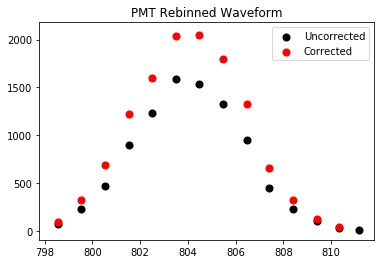

In [41]:
plt.scatter(rebinned_times/1000, s2_pmt, c="black", s=50, label="Uncorrected")

plt.scatter(rebinned_times/1000, E, c="r", s=50, label="Corrected" )

plt.legend()
plt.title("PMT Rebinned Waveform");